In [3]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [4]:
sales_s = pd.read_pickle("../Documents/Forecasting_Project/sales_s.pkl")
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


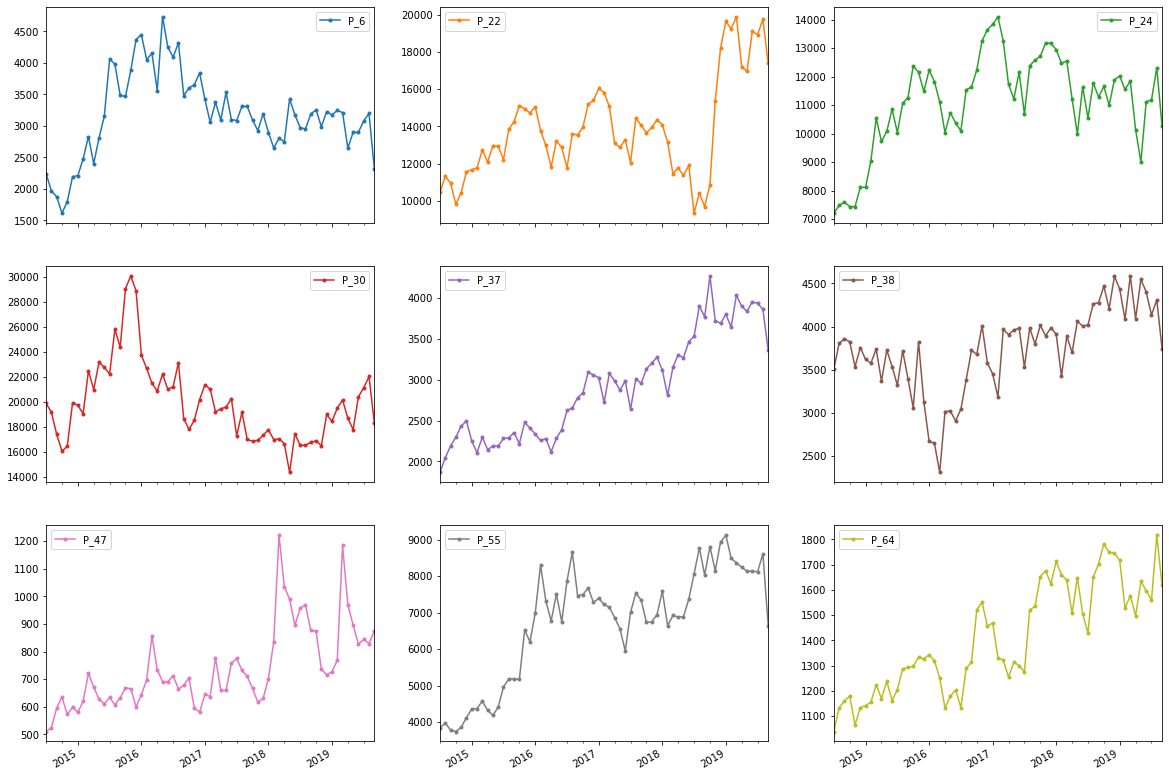

In [5]:
sales_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

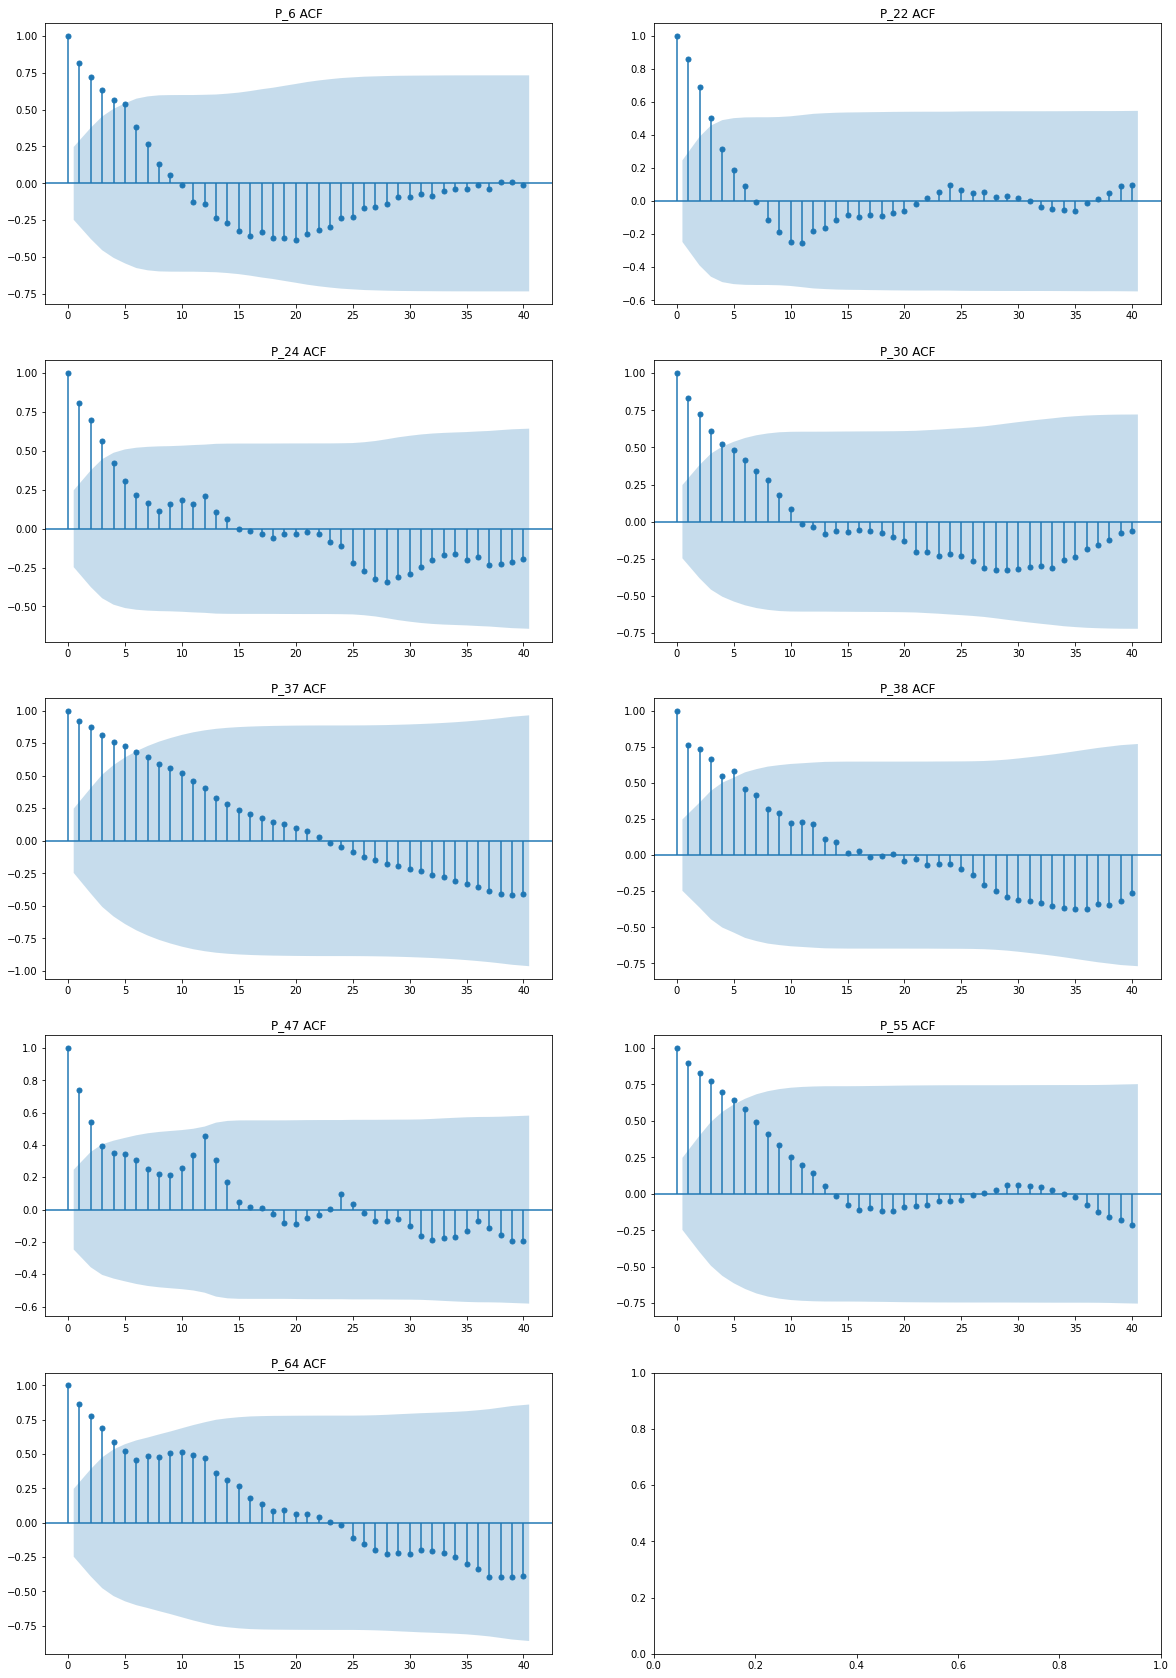

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(20, 30), sharex=False)
axs = axes.flatten()
alpha=.05
for i, col in enumerate(sales_s.columns):
    sm.graphics.tsa.plot_acf(sales_s[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

D'après les correlogrames des séries temporelles ci dessus, on peut constater que la fonction d'autocorrelation se dégrade ou diminue lentement, ce qui indique la non stationnarité des séries.
De plus, dans les deux séries des produits p_47 et p_64 l'ACF montre une oscillation et des pics qui se reproduisent avec des décalages de 12 mois indicant un effet de saisonnalité.

In [8]:
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), max(n_adf, n_kpss, n_pp))

In [9]:
res = pd.DataFrame(sales_s.columns, columns=["Series"])
res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(sales_s[i])[j]\
                                           for i in sales_s.columns] for j in range(7)]
res=res.set_index("Series")
res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
res

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Oui,Non,Oui,1
P_22,Non,Non,0,Oui,Oui,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_30,Non,Non,0,Oui,Oui,Oui,1
P_37,Non,Non,0,Oui,Oui,Non,1
P_38,Non,Non,0,Oui,Oui,Non,1
P_47,Non,Oui,1,Non,Oui,Non,1
P_55,Non,Non,0,Oui,Oui,Oui,1
P_64,Non,Oui,1,Non,Oui,Non,1


In [10]:
stationnaries = sales_s.copy()
stationnaries = stationnaries.diff(1).iloc[1:]
stationnaries.loc[:,["P_47", "P_64"]] = stationnaries.loc[:,["P_47", "P_64"]].diff(12)
stationnaries.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-08-31,-274.0,852.0,273.0,-688.0,178.0,294.0,NaN,131.0,NaN
2014-09-30,-93.0,-363.0,115.0,-1782.0,145.0,55.0,NaN,-193.0,NaN
2014-10-31,-262.0,-1134.0,-157.0,-1348.0,109.0,-36.0,NaN,-42.0,NaN
2014-11-30,181.0,605.0,-1.0,396.0,135.0,-288.0,NaN,116.0,NaN
2014-12-31,399.0,1141.0,675.0,3452.0,66.0,222.0,NaN,264.0,NaN


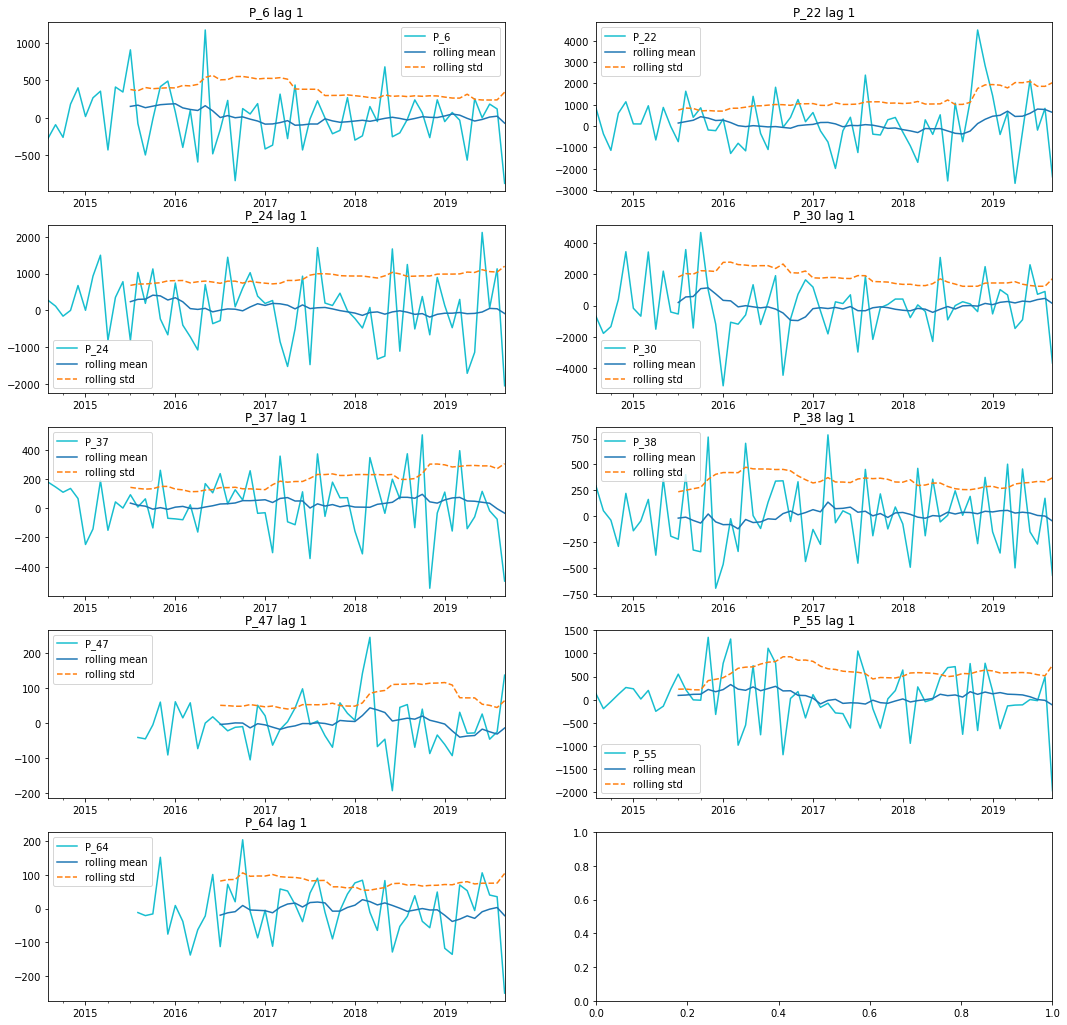

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(18, 18))
axs = axs.flatten()
cols = [next(color_cycle), next(color_cycle), next(color_cycle)]
for i, item in enumerate(sales_s.columns):
    stationnaries[item].plot(title=f"{item} lag 1",
                     color=cols[0],
                     ax=axs[i])
    stationnaries[item].rolling(12).mean().plot(
                     color=cols[1],
                     ax=axs[i], label="rolling mean")
    stationnaries[item].rolling(12).std().plot(
                     color=cols[2],
                     ax=axs[i], linestyle='--', label="rolling std")
    axs[i].legend()

In [16]:
res = pd.DataFrame(stationnaries.columns, columns=["Series"])
res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(stationnaries[i])[j]\
                                           for i in stationnaries.columns] for j in range(7)]
res=res.set_index("Series")
res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
res

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_6,Non,Non,0,Non,Non,Non,0
P_22,Non,Non,0,Non,Non,Non,0
P_24,Non,Non,0,Non,Non,Non,0
P_30,Non,Non,0,Non,Non,Non,0
P_37,Non,Non,0,Non,Non,Non,0
P_38,Non,Non,0,Non,Non,Non,0
P_47,Non,Non,0,Non,Non,Non,0
P_55,Non,Non,0,Non,Non,Non,0
P_64,Non,Non,0,Non,Non,Non,0


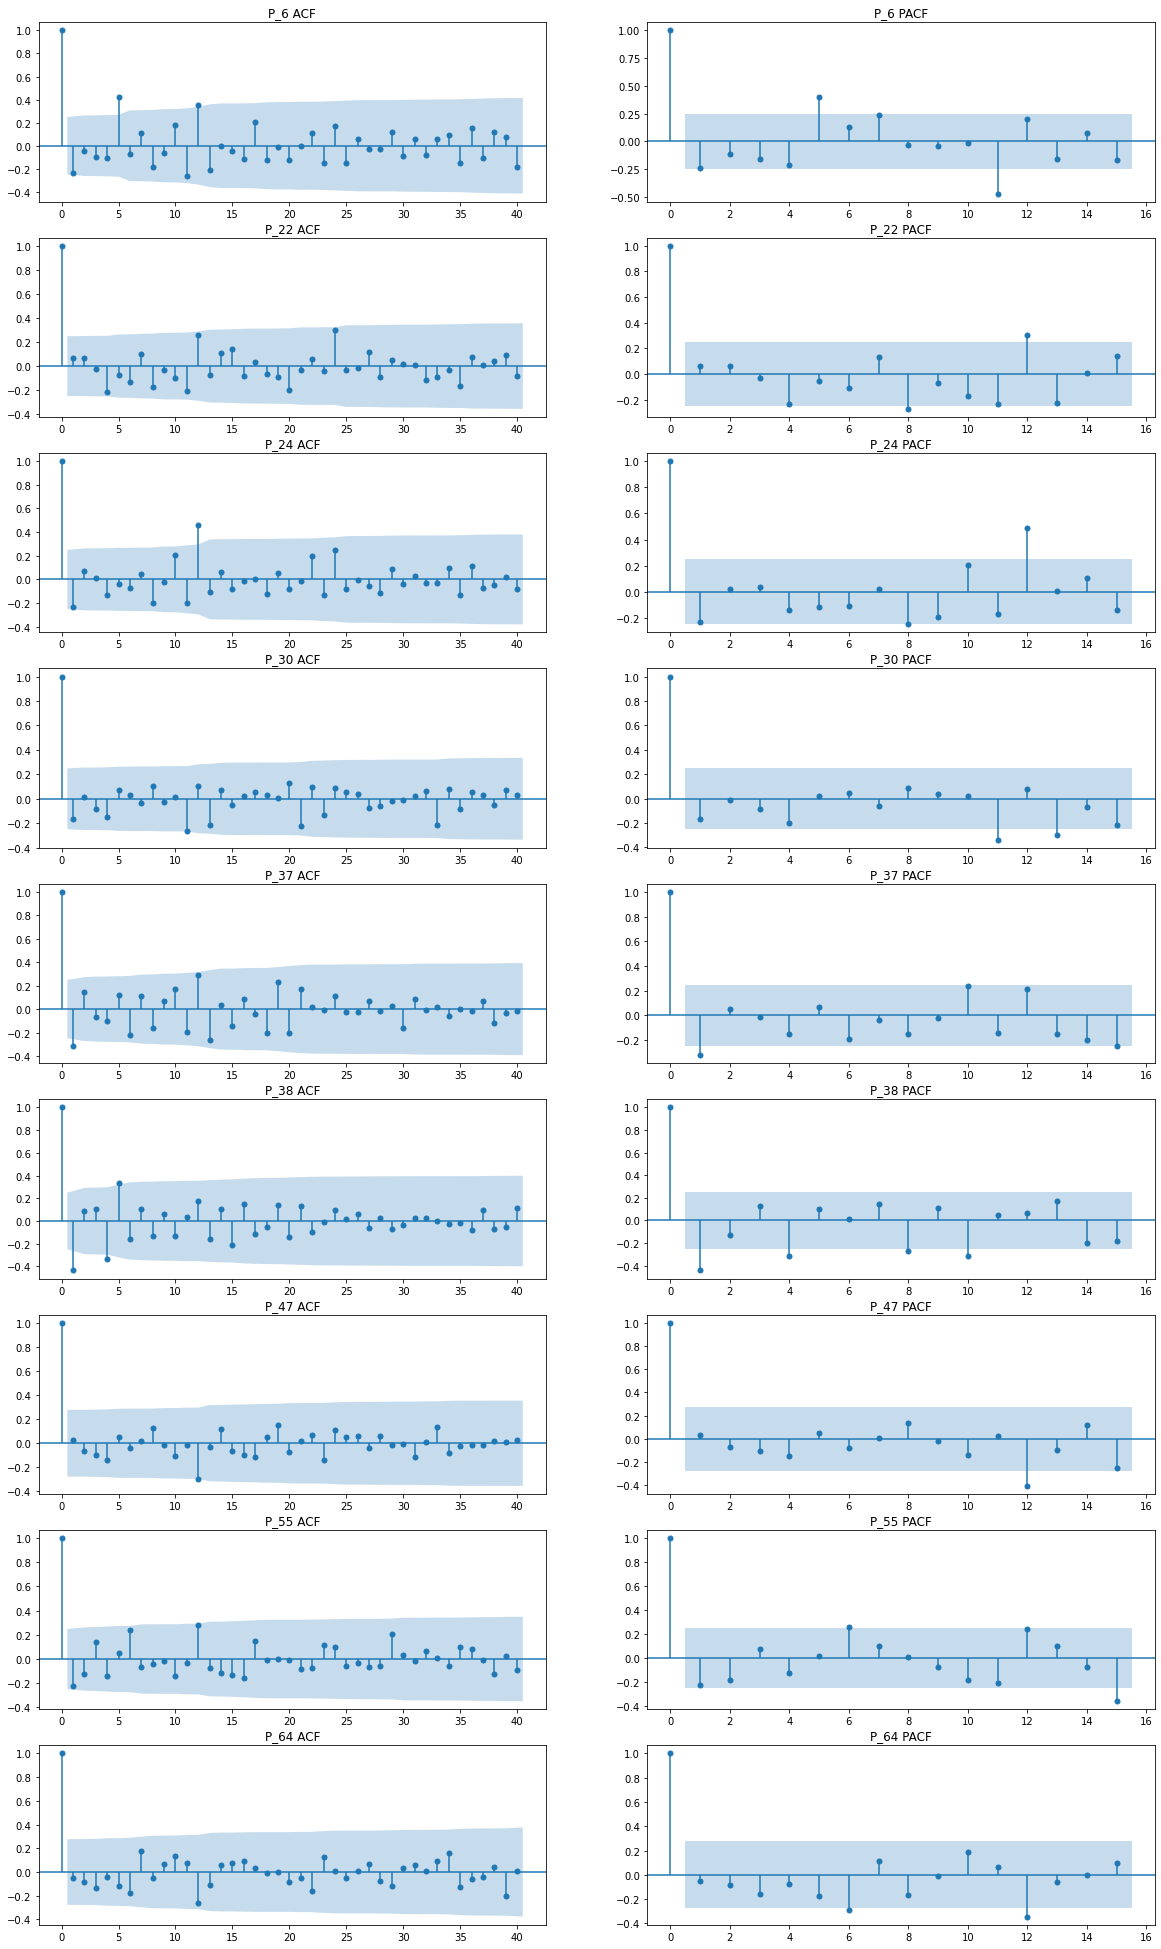

In [17]:
fig, axes = plt.subplots(9, 2, figsize=(20, 35), sharex=False)
alpha=.05
for i, col in enumerate(sales_s.columns):
    if col not in ("P_47", "P_64"):
        sm.graphics.tsa.plot_acf(sales_s[col].diff(1)[1:].values.squeeze(), lags=40, \
                                 ax=axes[i,0], title=f"{col} ACF", alpha=alpha)
        sm.graphics.tsa.plot_pacf(sales_s[col].diff(1)[1:].values.squeeze(), lags=15, \
                                  ax=axes[i,1], title=f"{col} PACF", alpha=alpha)
    else:
        sm.graphics.tsa.plot_acf(sales_s[col].diff(1).diff(12)[13:].values.squeeze(), lags=40, \
                                 ax=axes[i,0], title=f"{col} ACF", alpha=alpha)
        sm.graphics.tsa.plot_pacf(sales_s[col].diff(1).diff(12)[13:].values.squeeze(), lags=15, \
                                  ax=axes[i,1], title=f"{col} PACF", alpha=alpha)

In [18]:
models = [0]*len(sales_s.columns)
for i, col in enumerate(sales_s.columns):
    models[i] = pm.auto_arima(sales_s[col], start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=12,              # frequency of series
    #                       d=None,           # let model determine 'd'
    #                       seasonal=True,   # No Seasonality
    #                       start_P=0, 
    #                       D=0, 
#                           trace=True,
    #                       error_action='ignore',  
    #                       suppress_warnings=True, 
                          stepwise=True)

Must read : \
https://www.kddanalytics.com/practical-time-series-forecasting-deterministic-stochastic-trend-2/ \
https://otexts.com/fpp2/stochastic-and-deterministic-trends.html \
http://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [19]:
train_arima = sales_s.loc[:'2018-12-31']
test_arima = sales_s.loc['2019-01-31':]

In [20]:
sales_s.tail()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2019-05-31,2900,16956,9002,17768,3841,4548,896,8133,1634
2019-06-30,2899,19116,11119,20384,3956,4400,827,8137,1597
2019-07-31,3081,18930,11182,21106,3938,4134,844,8117,1560
2019-08-31,3198,19762,12311,22010,3863,4309,829,8612,1817
2019-09-30,2322,17386,10262,18321,3365,3742,875,6647,1618


In [21]:
pd.date_range("2019-10-31", periods=12, freq="m")

DatetimeIndex(['2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30'],
              dtype='datetime64[ns]', freq='M')

In [22]:
train_arima = sales_s.loc[:'2018-12-31']
test_arima = sales_s.loc['2019-01-31':] 

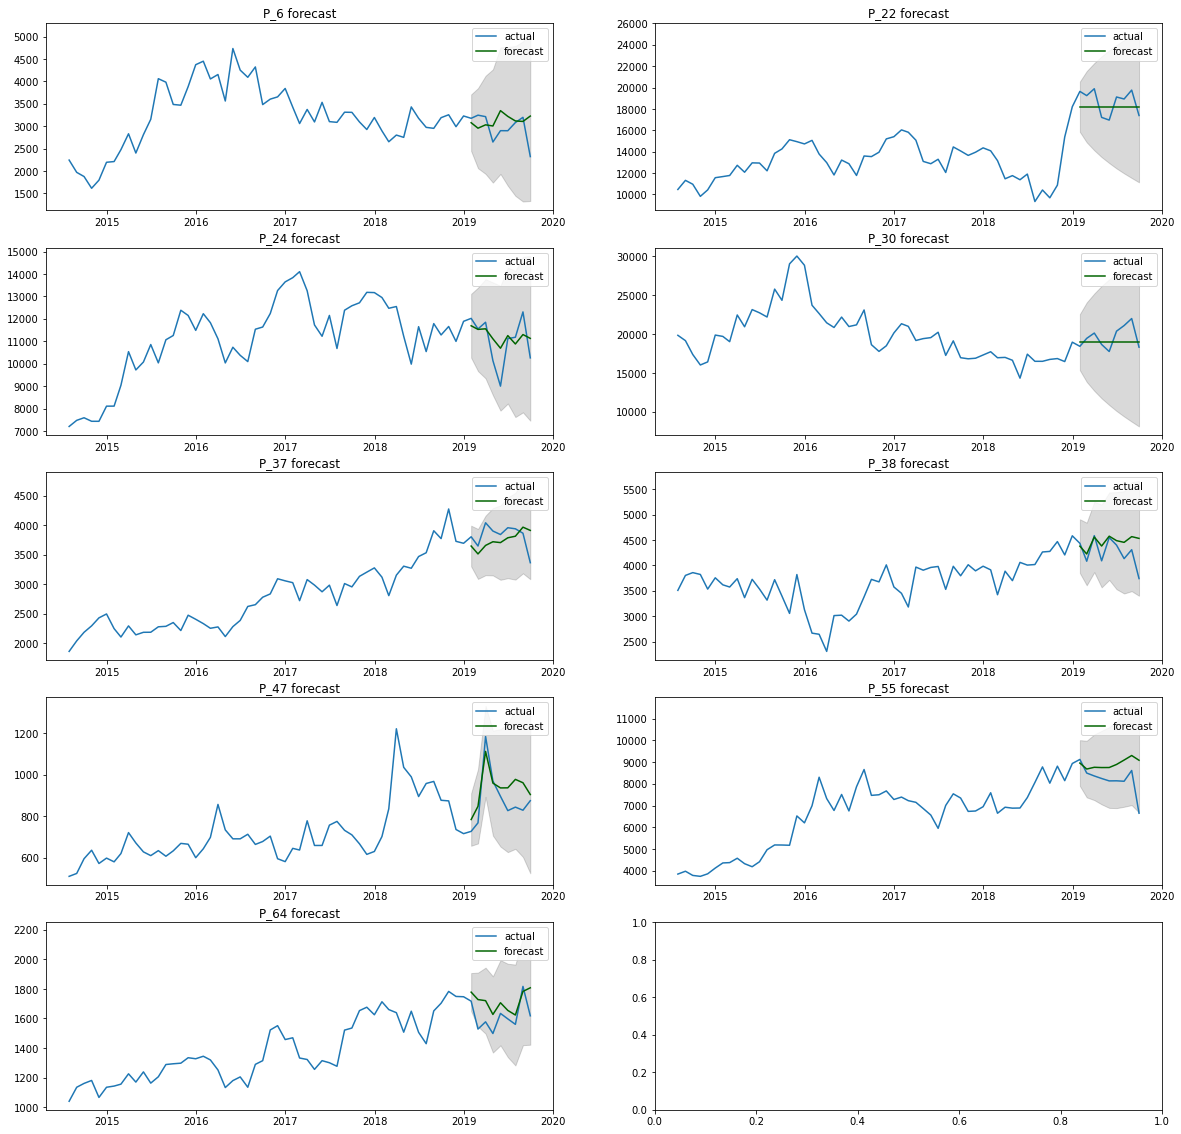

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
fitted_dynamic = [0]*len(sales_s.columns)
for i, item in enumerate(sales_s.columns):
    fitted_dynamic[i] = models[i].fit(train_arima.iloc[:,i])
    fc, confint = fitted_dynamic[i].predict(n_periods=9, return_conf_int=True)
    index_of_fc = sales_s.loc['2019-01-31':].index

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    axs[i].plot(sales_s.iloc[:,i], label="actual")
    axs[i].plot(fc_series, color='darkgreen', label="forecast")
    axs[i].fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    axs[i].set_title(f"{item} forecast")
    axs[i].legend()

In [24]:
test_arima

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2019-01-31,3176,19638,12023,18435,3803,4435,727,9120,1717
2019-02-28,3246,19246,11552,19459,3647,4083,768,8494,1528
2019-03-31,3213,19889,11850,20140,4040,4586,1185,8360,1577
2019-04-30,2647,17209,10140,18673,3900,4091,970,8244,1498
2019-05-31,2900,16956,9002,17768,3841,4548,896,8133,1634
2019-06-30,2899,19116,11119,20384,3956,4400,827,8137,1597
2019-07-31,3081,18930,11182,21106,3938,4134,844,8117,1560
2019-08-31,3198,19762,12311,22010,3863,4309,829,8612,1817
2019-09-30,2322,17386,10262,18321,3365,3742,875,6647,1618


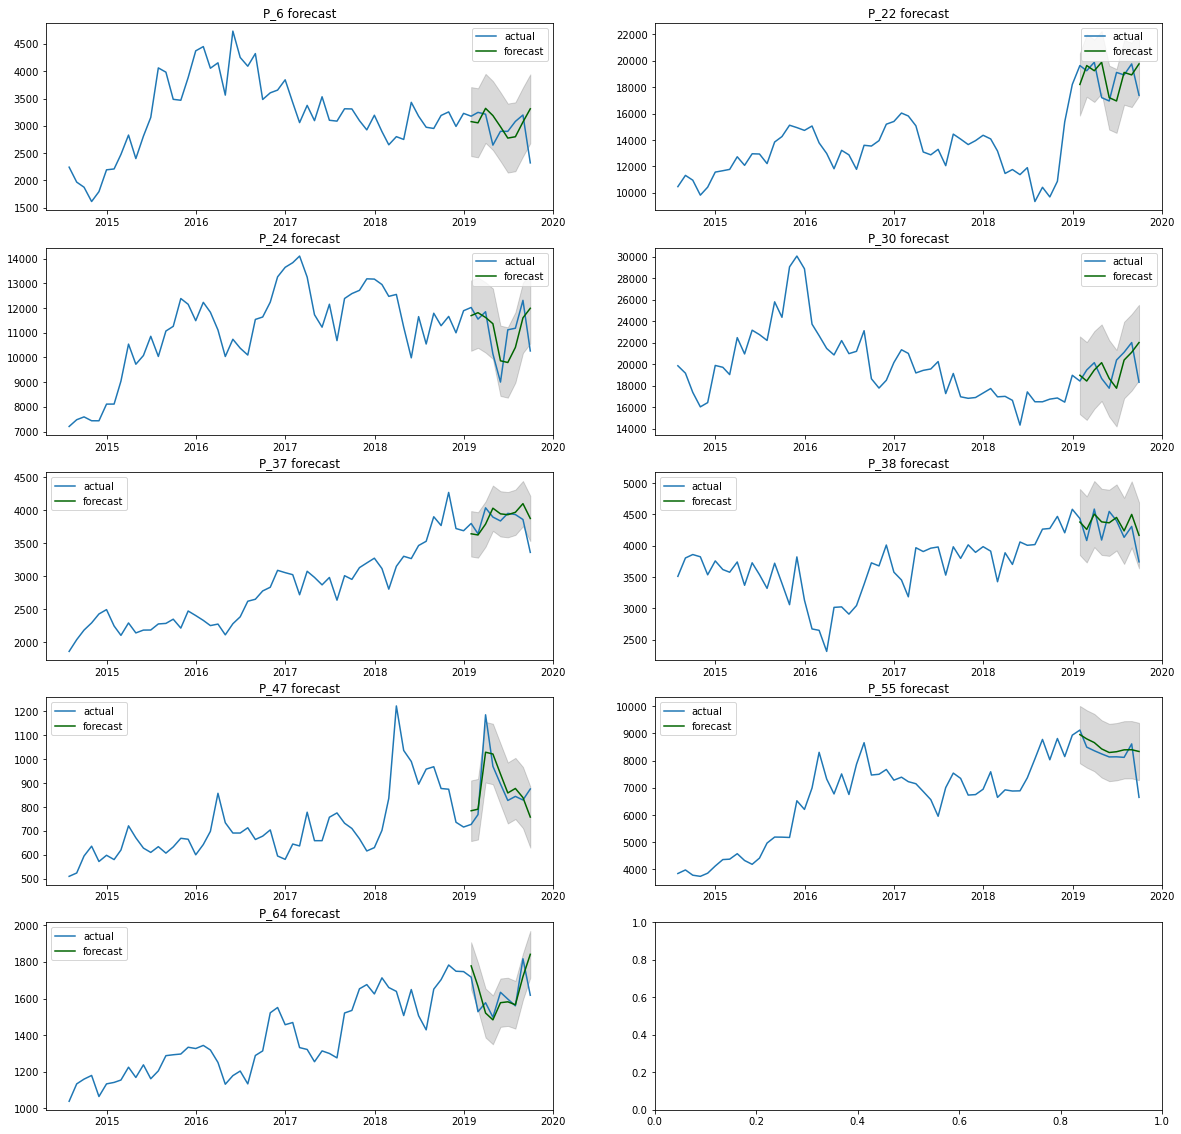

In [25]:
index_of_fc = sales_s.loc['2019-01-31':].index
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()
fitted_static = [0]*len(sales_s.columns)
for i, item in enumerate(sales_s.columns):
    fitted_static[i] = models[i].fit(train_arima.iloc[:,i])
    preds =np.zeros((len(test_arima)))
    conf_int = np.zeros((len(test_arima),2))

    for j in range(len(test_arima)):
        new_preds, new_conf_int = fitted_static[i].predict(n_periods=1, return_conf_int=True)
        fitted_static[i].update([test_arima.iloc[j,i]])
        preds[j] = new_preds
        conf_int[j] = new_conf_int


    # make series for plotting purpose
#     fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(conf_int[:, 0], index=index_of_fc)
    upper_series = pd.Series(conf_int[:, 1], index=index_of_fc)
    
    axs[i].plot(sales_s.iloc[:,i], label="actual")
    axs[i].plot(pd.Series(preds, index=index_of_fc), color='darkgreen', label="forecast")
    axs[i].fill_between(test_arima.iloc[:,i].index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)
    axs[i].set_title(f"{item} forecast")
    axs[i].legend()

Ljung-Box (Q) : \
    H0: The residuals are independently distributed.\
    H1: The residuals are not independently distributed; they exhibit serial correlation.\
    Prob(Q)<0.05   =>   the residuals are not independent


Heteroskedasticity (H):\
    H0: The null hypothesis is of no heteroskedasticity.\
    H1: heteroskedasticity.\
    Prob(H)<0.05   =>   heteroskedasticity.


Jarque-Bera (JB):\
    H0: Normality\
    H1: No normality\
    Prob(H)<0.05   =>   no normality

In [26]:
def Oui_non(x):
    return "Vérifié" if x else "Non" 

In [27]:
res = pd.DataFrame(columns=['Prob(Q)', 'Bruit Blanc', 'Prob(H)','Homoskedasticity','Prob(JB)','Normalité'])
for i in range(len(sales_s.columns)):
    tbl = models[i].summary().tables[2].data
    res = res.append({"Prob(Q)": float(tbl[1][1]), "Bruit Blanc": Oui_non(float(tbl[1][1])>0.05), \
                      "Prob(H)": float(tbl[3][1]), "Homoskedasticity": Oui_non(float(tbl[3][1])>0.05), \
                      "Prob(JB)": float(tbl[1][3]), "Normalité": Oui_non(float(tbl[1][3])>0.05)}\
                     ,ignore_index=True)
res.set_index(sales_s.columns)

,Prob(Q),Bruit Blanc,Prob(H),Homoskedasticity,Prob(JB),Normalité
P_6,0.43,Vérifié,0.73,Vérifié,0.29,Vérifié
P_22,0.60,Vérifié,0.00,Non,0.01,Non
P_24,0.60,Vérifié,0.65,Vérifié,0.34,Vérifié
P_30,0.18,Vérifié,0.09,Vérifié,0.50,Vérifié
P_37,1.00,Vérifié,0.00,Non,0.06,Vérifié
P_38,0.74,Vérifié,0.02,Non,0.49,Vérifié
P_47,0.89,Vérifié,0.10,Vérifié,0.00,Non
P_55,0.68,Vérifié,0.71,Vérifié,0.40,Vérifié
P_64,0.27,Vérifié,0.69,Vérifié,0.28,Vérifié


In [28]:
# import pmdarima
# import arch

# # fit ARIMA on returns 
# arima_model = models[5]
# arima_residuals = arima_model.arima_res_.resid

# # fit a GARCH(1,1) model on the residuals of the ARIMA model
# garch = arch.arch_model(arima_residuals, p=1, q=1)
# garch_model = garch.fit()

# # Use ARIMA to predict mu
# predicted_mu = arima_model.predict(n_periods=9)
# print("here : ", predicted_mu)
# # Use GARCH to predict the residual
# garch_forecast = garch_model.forecast(horizon=9)
# predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# print("here : ", predicted_et)
# # Combine both models' output: yt = mu + et
# prediction = predicted_mu + predicted_et

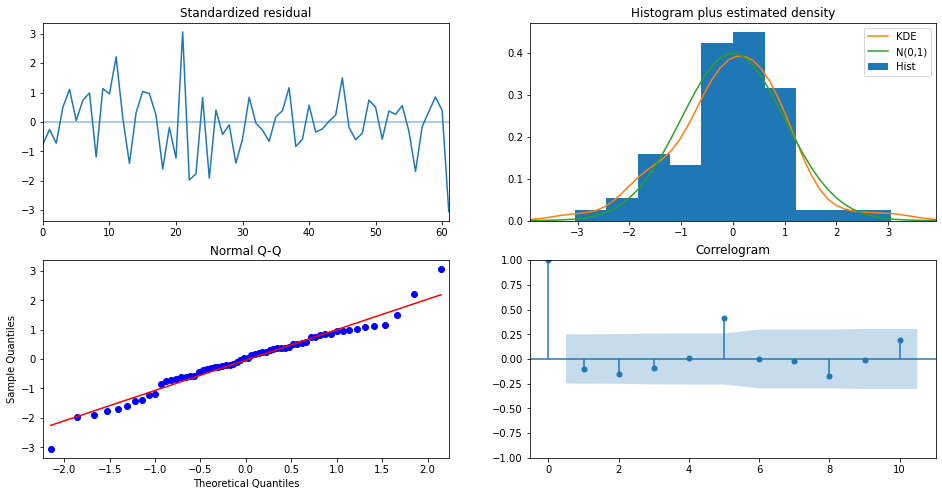

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -449.587
Date:                            Wed, 16 Jun 2021   AIC                            903.174
Time:                                    12:21:51   BIC                            907.428
Sample:                                         0   HQIC                           904.845
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4503      0.101      4.460      0.000       0.252       0.648
sigma2      1.036e+05   1.42e+04      7.299      0.000    7.58e+04    1.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.43   Prob(JB):                         0.29
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

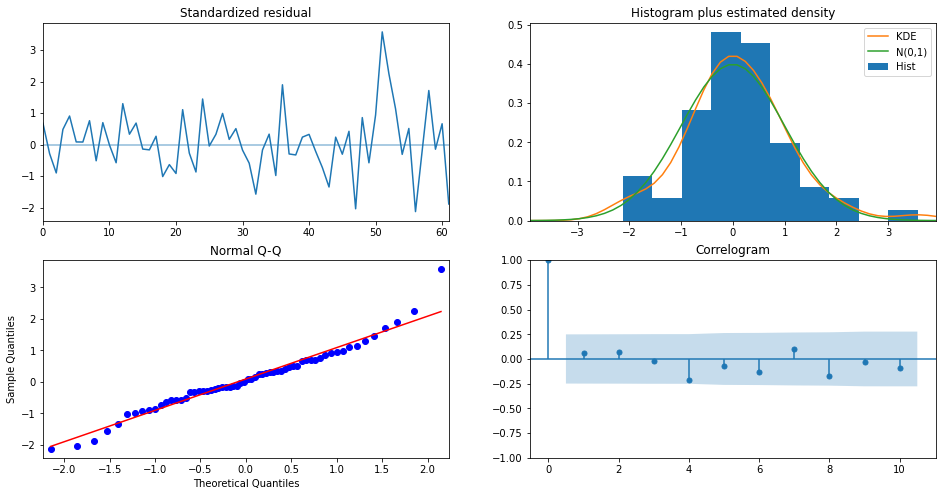

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -530.559
Date:                Wed, 16 Jun 2021   AIC                           1063.119
Time:                        12:21:53   BIC                           1065.246
Sample:                             0   HQIC                          1063.954
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.585e+06    2.1e+05      7.558      0.000    1.17e+06       2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 8.43
Prob(Q):                              0.60   Prob(JB):                         0.01
Heteroskedasticity (H):               4.56   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

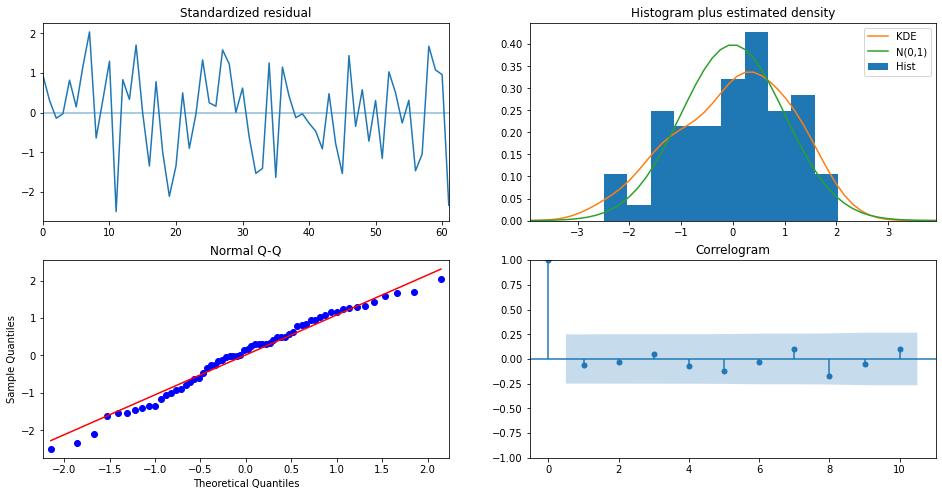

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -502.138
Date:                             Wed, 16 Jun 2021   AIC                           1010.275
Time:                                     12:21:54   BIC                           1016.657
Sample:                                          0   HQIC                          1012.781
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.097     -1.834      0.067      -0.366       0.012
ar.S.L12       0.4572      0.073      6.284      0.000       0.315       0.600
sigma2       5.28e+05   1.15e+05      4.610      0.000    3.04e+05    7.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.60   Prob(JB):                         0.34
Heteroskedasticity (H):               0.82   Skew:                            -0.35
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

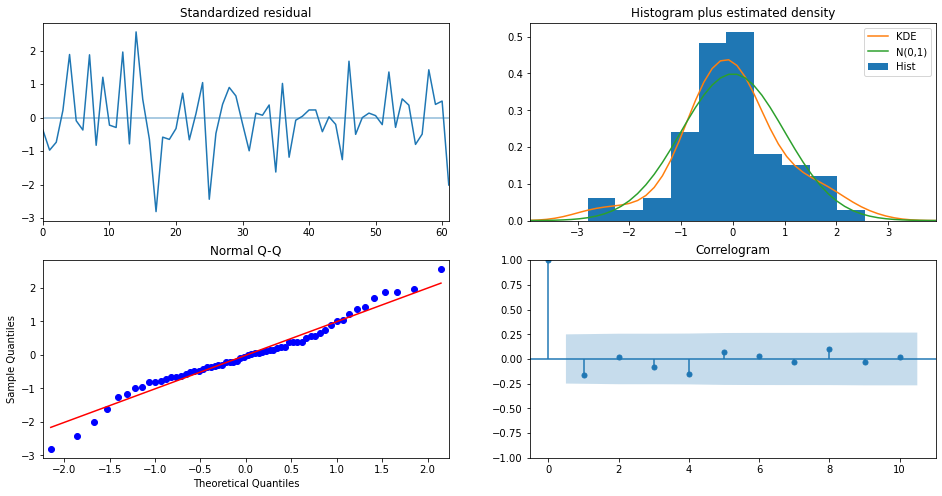

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -553.969
Date:                Wed, 16 Jun 2021   AIC                           1109.939
Time:                        12:21:55   BIC                           1112.066
Sample:                             0   HQIC                          1110.774
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.366e+06   5.16e+05      6.519      0.000    2.35e+06    4.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.18   Prob(JB):                         0.50
Heteroskedasticity (H):               0.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

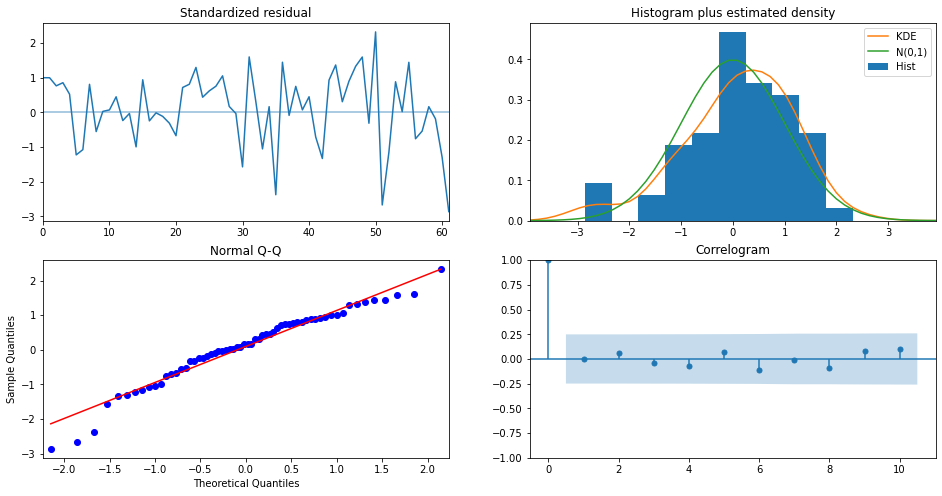

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -411.987
Date:                            Wed, 16 Jun 2021   AIC                            829.975
Time:                                    12:21:56   BIC                            836.356
Sample:                                         0   HQIC                           832.480
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.097     -2.542      0.011      -0.436      -0.056
ar.S.L12       0.3784      0.126      2.997      0.003       0.131       0.626
sigma2      3.064e+04   4852.938      6.314      0.000    2.11e+04    4.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.49
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               3.79   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

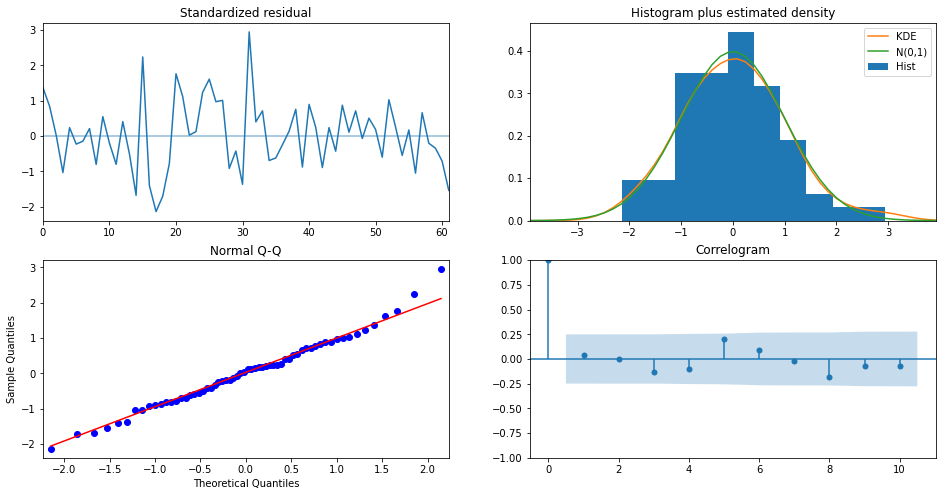

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -434.691
Date:                             Wed, 16 Jun 2021   AIC                            881.382
Time:                                     12:21:57   BIC                            894.145
Sample:                                          0   HQIC                           886.393
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3197      0.165     -8.018      0.000      -1.642      -0.997
ar.L2         -0.5661      0.111     -5.101      0.000      -0.784      -0.349
ma.L1          0.8918      0.140      6.364      0.000       0.617       1.166
ar.S.L12       0.1837      0.172      1.071      0.284      -0.153       0.520
ar.S.L24       0.2227      0.250      0.890      0.373      -0.267       0.713
sigma2      7.281e+04   1.49e+04      4.873      0.000    4.35e+04    1.02e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.74   Prob(JB):                         0.49
Heteroskedasticity (H):               0.34   Skew:                             0.33
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

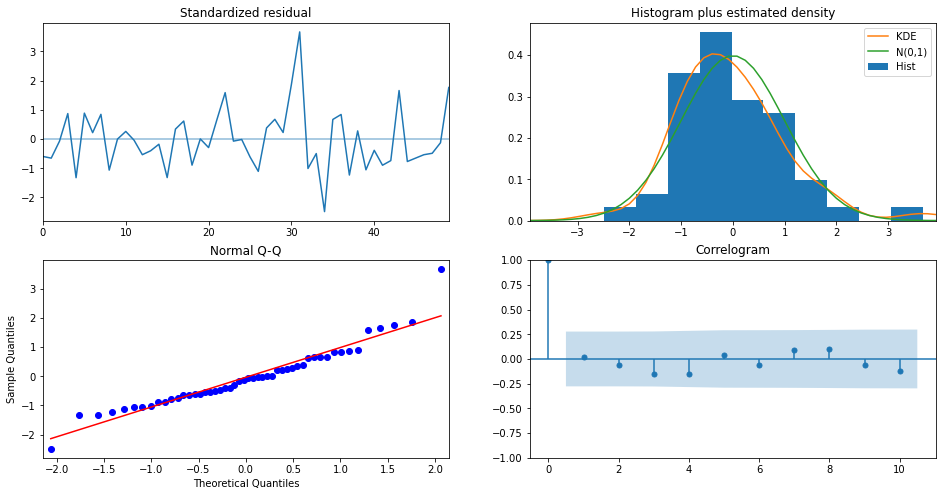

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -281.499
Date:                            Wed, 16 Jun 2021   AIC                            566.999
Time:                                    12:21:59   BIC                            570.823
Sample:                                         0   HQIC                           568.455
                                             - 63                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3158      0.122     -2.595      0.009      -0.554      -0.077
sigma2      4258.8316    593.644      7.174      0.000    3095.310    5422.353
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.03
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             0.92
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

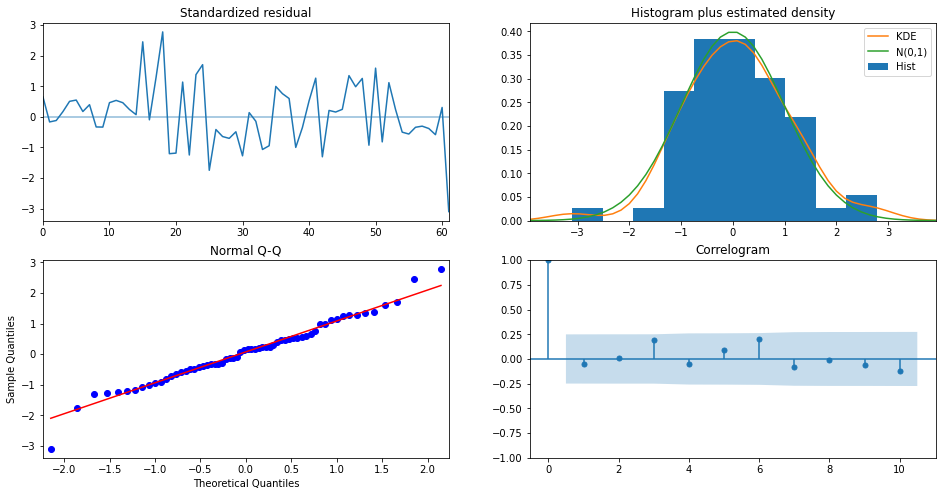

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   63
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -479.358
Date:                             Wed, 16 Jun 2021   AIC                            964.717
Time:                                     12:22:00   BIC                            971.098
Sample:                                          0   HQIC                           967.222
                                              - 63                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2705      0.117     -2.306      0.021      -0.500      -0.041
ar.S.L12       0.3422      0.142      2.418      0.016       0.065       0.620
sigma2      2.886e+05   4.51e+04      6.399      0.000       2e+05    3.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.68   Prob(JB):                         0.40
Heteroskedasticity (H):               1.18   Skew:                            -0.02
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

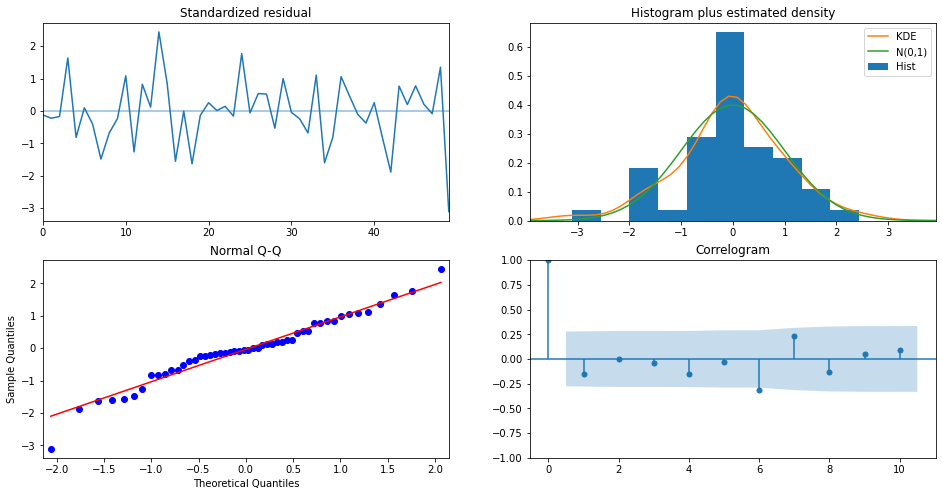

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -290.064
Date:                              Wed, 16 Jun 2021   AIC                            584.128
Time:                                      12:22:01   BIC                            587.952
Sample:                                           0   HQIC                           585.584
                                               - 63                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9923     11.101     -0.089      0.929     -22.750      20.765
sigma2      4344.9212   4.76e+04      0.091      0.927    -8.9e+04    9.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.27   Prob(JB):                         0.28
Heteroskedasticity (H):               1.22   Skew:                            -0.34
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
for i in range(len(sales_s.columns)):
    models[i].plot_diagnostics(figsize=(16,8))
    plt.show()
    display(models[i].summary())